## LinearRegressionArchitecture_Workshop
Chao-Chung ,Liu

## 📂 Project Structure Overview

This project follows the **MLOps (Machine Learning Operations)** architectural patterns to ensure reproducibility and modularity.

| Directory / File | Description |
| :--- | :--- |
| **`data/raw/`** | **Raw Data**: Stores immutable original CSV files (e.g., `RMBR4-2_export_test.csv`). These files should never be edited manually. |
| **`data/processed/`** | **Processed Data**: Stores cleaned and transformed datasets ready for model training. |
| **`notebooks/`** | **Jupyter Notebooks**: `EDA.ipynb` for data exploration; `linear_regression.ipynb` for model prototyping. |
| **`src/`** | **Source Code**: Modular Python scripts for data loading, preprocessing, model definition, and evaluation. |
| **`configs/`** | **Configurations**: YAML files to manage experiment parameters (e.g., learning rates, paths) without changing code. |
| **`experiments/`** | **Experiment Tracking**: Automatically logs performance metrics (e.g., RMSE, R² scores) for each run. |
| **`requirements.txt`** | **Dependencies**: Lists all Python packages required to run the project. |
| **`README.md`** | **Documentation**: Summary of work, design decisions, and step-by-step instructions. |

## 🌐1.import selfmod

In [21]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath('../'))

from src.data_loader import load_from_csv, load_from_db, load_config
from src.preprocessing import clean_robot_data, apply_smoothing, prepare_features
from src.model import ManualLinearRegression
from src.evaluation import evaluate_model, plot_regression_results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 🌐2.Manual Implementation

def Hypothesis Function & Cost Function

* Hypothesis Function : It is the mathematical formula that the model uses to make predictions. In linear regression, we assume a linear relationship between the input features $x$ and the output $y$.

    ### Mathematical Formula: $h_\theta(x) = \theta_0 + \theta_1 x$

        $\theta_0$: The Intercept, representing the predicted value when $x=0$.

        $\theta_1$: The Slope, representing the change in $y$ for every unit change in $x$.

        In your robot project: $x$ is "Time" and $y$ is "Predicted Current."

* Cost Function : An indicator that measures how "inaccurate" the model's predictions are. A lower cost function value means the predictions are closer to the actual data. The most common method is Mean Squared Error (MSE).

    ### Mathematical Formula: $J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2$

        It calculates the difference between "Predictions" and "Actual Values," squares them (to remove signs and amplify errors).

        $m$ represents the number of data points.

        Our goal is to find the parameters $\theta$ that minimize $J(\theta)$.

In [22]:
def hypothesis(theta, X):

    # Hypothesis Function: h(x) = theta0 + theta1 * x

    return np.dot(X, theta)

def compute_cost(X, y, theta):

    # Cost Function (Mean Squared Error)
    # J(theta) = (1/2m) * sum((h(x) - y)^2)

    m = len(y)
    predictions = hypothesis(theta, X)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

## 🌐3.Gradient Descent

In [23]:
def gradient_descent(X, y, theta, learning_rate, iterations):

    # Gradient Descent Algorithm

    m = len(y)
    cost_history = []

    for i in range(iterations):
        predictions = hypothesis(theta, X)
        # Update rule
        errors = predictions - y
        gradient = (1 / m) * np.dot(X.T, errors)
        theta = theta - learning_rate * gradient
        
        # Record cost for each iteration
        cost_history.append(compute_cost(X, y, theta))
        
    return theta, cost_history

* Hypothesis Function is responsible for "guessing" the answer.
* Cost Function is responsible for "grading," telling the model how well it guessed.
* The subsequent Gradient Descent then "corrects" the $\theta$ in the hypothesis function based on the grade, until the grade is highest (cost is lowest).

## 🌐4.Data Preparation
Read the data, perform smoothing processing, and convert the data into matrix format.

In [24]:
# Load and clean
df_raw = load_from_csv('../data/raw/RMBR4-2_export_test.csv')
df_clean = clean_robot_data(df_raw)
df_smooth = apply_smoothing(df_clean, 'Axis #1', window_size=100)

# Independent variable(IV) X and Dependent variable(DV) y
# predict 'Axis #1_smooth' using 'Elapsed_Seconds'
X = df_smooth[['Elapsed_Seconds']].values
y = df_smooth['Axis #1_smooth'].values

# Feature Scaling
X_mean = np.mean(X)
X_std = np.std(X)
X_scaled = (X - X_mean) / X_std

# Add a column of ones for theta0
X_final = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

# Initialize parameters
theta_initial = np.zeros(2) # [theta0, theta1]

✅ CSV Loaded: ../data/raw/RMBR4-2_export_test.csv


## 🌐5.Model Training
Find the optimal  $\theta$

In [25]:
# Set hyperparameters
learning_rate = 0.01
iterations = 1000

#  Run Gradient Descent
theta_final, cost_history = gradient_descent(X_final, y, theta_initial, learning_rate, iterations)

print(f"Training Complete!")
print(f"Final Theta: {theta_final}")
print(f"Final Cost: {cost_history[-1]}")

Training Complete!
Final Theta: [ 0.72573681 -0.00250171]
Final Cost: 0.1645507809622131


## 🌐6.Visualizing Results

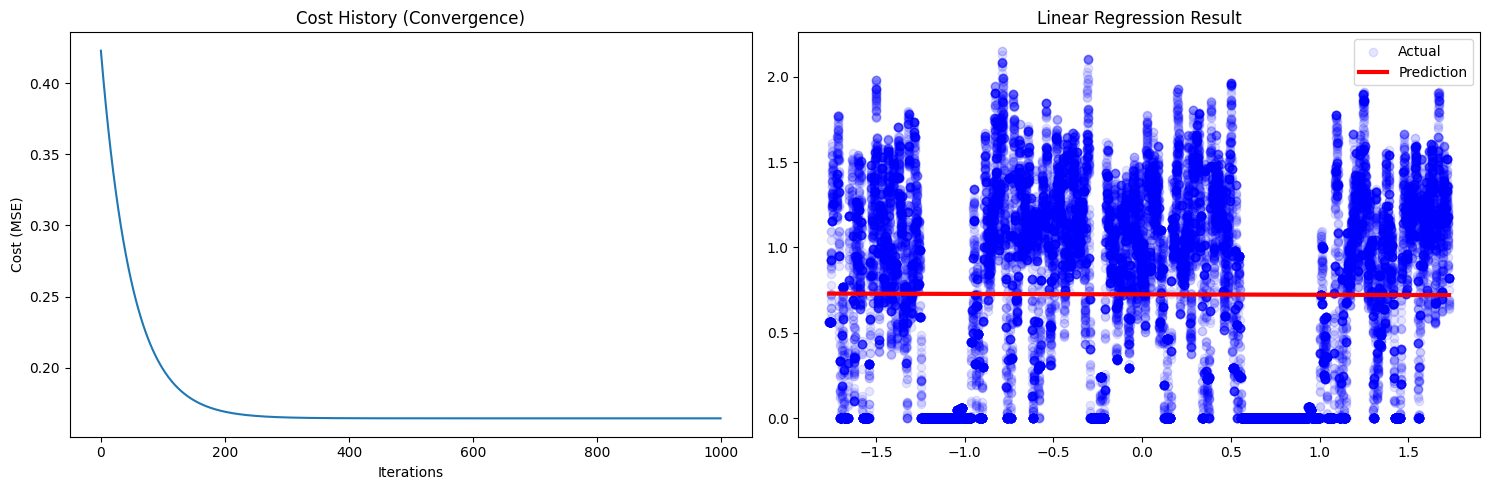

In [26]:
plt.figure(figsize=(15, 5))

# A：Cost History
plt.subplot(1, 2, 1)
plt.plot(cost_history)
plt.title("Cost History (Convergence)")
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")

# B：Regression Line vs Data
plt.subplot(1, 2, 2)
plt.scatter(X_scaled, y, color='blue', alpha=0.1, label='Actual')
plt.plot(X_scaled, hypothesis(theta_final, X_final), color='red', linewidth=3, label='Prediction')
plt.title("Linear Regression Result")
plt.legend()

plt.tight_layout()
plt.show()

## 🌐7.RMSE & $R^2$ 

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

# Get predictions from our manual model
y_pred = hypothesis(theta_final, X_final)

# Calculate RMSE
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

# Calculate R2 Score
r2 = r2_score(y, y_pred)

print(f"--- Model Evaluation ---")
print(f"RMSE: {rmse:.4f} (The average prediction error is approximately {rmse:.4f})")
print(f"R2 Score: {r2:.4f}")

--- Model Evaluation ---
RMSE: 0.5737 (The average prediction error is approximately 0.5737)
R2 Score: 0.0000


## 🌐8.Scikit-Learn VS Scikit-Learn Comparison

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Initialize and train Scikit-Learn model
# We use X_scaled (without intercept) as Sklearn handles it automatically
X_sklearn = X_scaled.reshape(-1, 1)
model_sk = LinearRegression()
model_sk.fit(X_sklearn, y)

# Get predictions and metrics
y_pred_sk = model_sk.predict(X_sklearn)
rmse_sk = np.sqrt(mean_squared_error(y, y_pred_sk))
mae_sk = mean_absolute_error(y, y_pred_sk)
r2_sk = r2_score(y, y_pred_sk)

# Create a comparison table
comparison_data = {
    "Metrics": ["Theta 0 (Intercept)", "Theta 1 (Slope)", "RMSE", "MAE", "R2 Score"],
    "Manual": [theta_final[0], theta_final[1], rmse, "需計算", r2],
    "Scikit-Learn": [model_sk.intercept_, model_sk.coef_[0], rmse_sk, mae_sk, r2_sk]
}

df_compare = pd.DataFrame(comparison_data)
display(df_compare)

,Metrics,Manual,Scikit-Learn
0,Theta 0 (Intercept),0.725737,0.725768
1,Theta 1 (Slope),-0.002502,-0.002502
2,RMSE,0.573674,0.573674
3,MAE,需計算,0.512128
4,R2 Score,0.000019,0.000019


# ☼Refactoring

Now I have model.py & evaluation.py

## ☼1.Module Imports

In [29]:
import sys
import os
import pandas as pd
import numpy as np

## ☼2.Data Pipeline
Using modular functions, complex preprocessing can be completed in just a few lines of code.

In [30]:
config_path = '../configs/experiment_config.yaml'
config = load_config(config_path)

if config.get('database', {}).get('enabled', False):
    print("🌐 from neao...")
    df = load_from_db(config['database']['db_url'], config['database']['table_name'])
else:
    print("📁 location...")
    df = load_from_csv('../data/raw/RMBR4-2_export_test.csv')


# Load, Clean, Smooth
if df is not None:
    df = clean_robot_data(df)
    df = apply_smoothing(df, 'Axis #1', window_size=config['model_params']['window_size'])

# Prepare Features and Target
X = df[['Elapsed_Seconds']].values
y = df['Axis #1_smooth'].values

X_scaled = (X - np.mean(X)) / np.std(X)

✅Config loaded: ../configs/experiment_config.yaml
📁 location...
✅ CSV Loaded: ../data/raw/RMBR4-2_export_test.csv


## ☼4.Data Splitting 
60% Train Set & 40% Test Set

In [31]:
lr = config['model_params']['learning_rate']
iters = config['model_params']['iterations']

model = ManualLinearRegression(learning_rate=lr, iterations=iters)

from sklearn.model_selection import train_test_split

# Split data: 60% Train, 40% Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, shuffle=False  
)

# Train with 60% data
model.fit(X_train, y_train)

# Predict with 40% data
y_test_pred = model.predict(X_test)

print(f"✅ Train: {len(X_train)} , Predict : {len(X_test)} ")

✅ Train: 23803 , Predict : 15869 


## ☼5.Training & Evaluation

[Manual Linear Regression] RMSE: 0.4713
[Manual Linear Regression] R2 Score: 0.0003


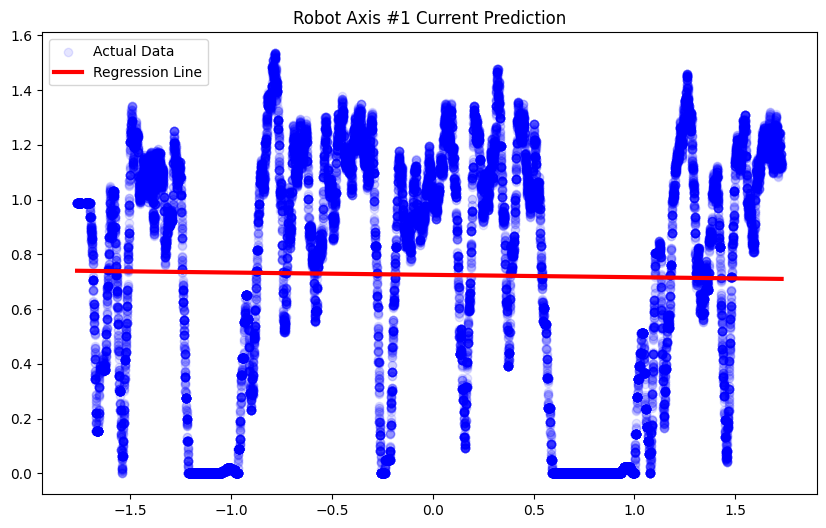

In [32]:
# Instantiate the model
model = ManualLinearRegression(learning_rate=0.01, iterations=1000)

# Fit the model
model.fit(X_scaled, y)

# Make predictions
y_pred = model.predict(X_scaled)

# Evaluate performance metrics
metrics = evaluate_model(y, y_pred, label="Manual Linear Regression")

# Plot fitting results
plot_regression_results(X_scaled, y, y_pred, title="Robot Axis #1 Current Prediction")

## ☼6.Metrics
Compare the errors of the "training set" and the "test set".

Train RMSE: 0.4458
Test RMSE: 0.7027
Original average current: 0.7257 A
Smoothed average current: 0.7248 A


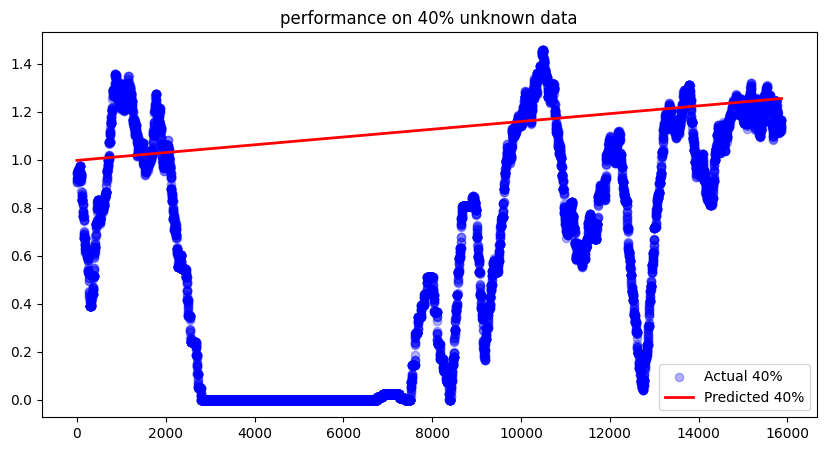

In [33]:
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

original_mean = df['Axis #1'].mean()
smoothed_mean = df['Axis #1_smooth'].mean()

print(f"Original average current: {original_mean:.4f} A")
print(f"Smoothed average current: {smoothed_mean:.4f} A")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.3, label='Actual 40%')
plt.plot(range(len(y_test)), y_test_pred, color='red', linewidth=2, label='Predicted 40%')
plt.title('performance on 40% unknown data')
plt.legend()
plt.show()

# Configuration-driven
To align with the "Configuration-driven" MLOps design pattern used in the workshop, we need to enable the program to automatically read parameters from the YAML file, rather than requiring manual input. This ensures the reproducibility and modularity of the experiments.

## Implementing automated reading

In [34]:
from src.data_loader import load_config

# Load config
config = load_config('../configs/experiment_config.yaml')

# Extract parameters from config
lr = config['model_params']['learning_rate']
iters = config['model_params']['iterations']
win_size = config['model_params']['window_size']
data_path = config['data']['raw_path']

# use these parameters for subsequent processes
df = load_from_csv(data_path)
df = apply_smoothing(df, 'Axis #1', window_size=win_size)

# Training Model
model = ManualLinearRegression(learning_rate=lr, iterations=iters)
# Training NNN

✅Config loaded: ../configs/experiment_config.yaml
✅ CSV Loaded: ../data/raw/RMBR4-2_export_test.csv


## ≌1.Predictive maintenance and alarm logic

In [35]:
# Get configuration settings from YAML
threshold = config['maintenance']['failure_threshold']
alert_days = config['maintenance']['alert_buffer_days']

## Model Initialization and Training

# Instantiate model with hyperparameters
model = ManualLinearRegression(learning_rate=lr, iterations=iters)

# Execute training to calculate Theta parameters
model.fit(X_scaled, y)

# Extract trained parameters (Intercept and Slope)
theta0 = model.theta[0]
theta1 = model.theta[1]

print(f"--- Predictive Maintenance Analysis ---")
print(f"Failure Threshold: {threshold} ")

# Predict the point of failure (when h(x) = threshold)
#  x = (threshold - theta0) / theta1
#  x = (Threshold - Intercept) / Slope

if theta1 > 0:
    predicted_failure_time_scaled = (threshold - theta0) / theta1
    print(f"⚠️ Trend analysis: Predicted failure at standardized time {predicted_failure_time_scaled:.2f} ")
    
    print(f"📢 Alert system active: Notifications will be sent {alert_days} days before failure.")
else:

    print(f"✅Status: Current slope is {theta1:.6f},rend is stable with no immediate risk.")

--- Predictive Maintenance Analysis ---
Failure Threshold: 1.0 
✅Status: Current slope is -0.008522,rend is stable with no immediate risk.


## ≌2.Plotting

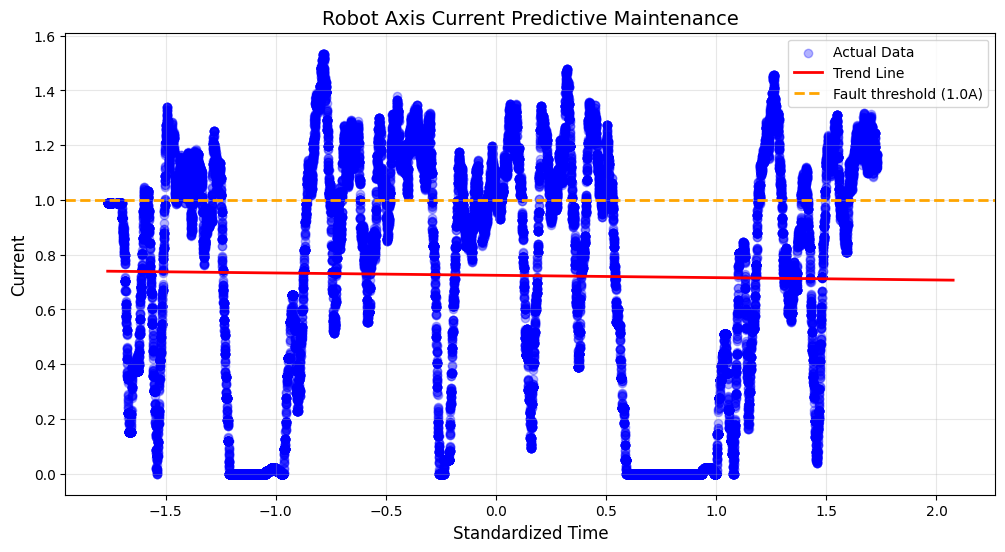

In [36]:
import matplotlib.pyplot as plt

# Prepare data for plotting
# Create an extended X-axis to see when the prediction hits the threshold
x_min = X_scaled.min()
x_max = max(X_scaled.max(), (predicted_failure_time_scaled if theta1 > 0 else X_scaled.max()))
X_extended = np.linspace(x_min, x_max * 1.2, 100).reshape(-1, 1)
X_extended_final = np.c_[np.ones(X_extended.shape[0]), X_extended]

# Calculate extended predictions
y_extended_pred = np.dot(X_extended_final, model.theta)

# Start Plotting
plt.figure(figsize=(12, 6))

# Plot actual observed data
plt.scatter(X_scaled, y, color='blue', alpha=0.3, label='Actual Data')

# Plot the model's trend line
plt.plot(X_extended, y_extended_pred, color='red', linewidth=2, label='Trend Line')

# Plot the failure threshold horizontal line
plt.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Fault threshold ({threshold}A)')

# Mark the failure point if slope is positive
if theta1 > 0:
    plt.plot(target_x_scaled, threshold, 'ro', markersize=10, label='Predicted Failure')
    plt.annotate(f'Predicted Failure Point\n(Time: {target_x_scaled:.2f})',
                 xy=(target_x_scaled, threshold), xytext=(target_x_scaled-1, threshold+0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))

# Chart Settings
plt.title('Robot Axis Current Predictive Maintenance', fontsize=14)
plt.xlabel('Standardized Time', fontsize=12)
plt.ylabel('Current', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)



plt.show()

## ≌ Remaining Useful Life, RUL

In [37]:
# Get stats for inverse scaling
X_mean = np.mean(X)
X_std = np.std(X)

# Unit conversion
if theta1 > 0:
    # Convert standardized time back to actual seconds
    failure_seconds = (predicted_failure_time_scaled * X_std) + X_mean
    
    # Convert to days (1 day = 86400 seconds)
    failure_days_from_start = failure_seconds / 86400
    
    # Calculate "Remaining" days
    # X.max()
    current_days = X.max() / 86400
    days_until_failure = failure_days_from_start - current_days
    
    print(f"--- Prediction Result ---")
    print(f"⏰ The robot is expected to reach the failure threshold ({threshold} in {days_until_failure:.1f}  )。")
    
    # Check if within 2-week alert buffer
    if days_until_failure <= alert_days:
        print("🚨Alert: The device has entered a 14-day warning period. Please arrange maintenance as soon as possible!")
    else:
        print(f"✅ The device currently has {days_until_failure:.1f} days of safe operation.")
else:
    print("✅ Stable trend: The current slope has not increased, and the failure date cannot be calculated at present (device health。")

✅ Stable trend: The current slope has not increased, and the failure date cannot be calculated at present (device health。


## ≌Smoothing Sensitivity Experiment(Hyperparameter Sweep)
By experimenting with different window sizes (smoothness), we can determine which parameter makes the model's predictions most accurate (with the lowest RMSE).

In [ ]:
# 🚀Hyperparameter Sweep
window_sizes = [100, 300, 500]
results = []

# Ensure we use the raw dataframe for each iteration
df_raw_backup = load_from_csv(config['data']['raw_path']) 

for ws in window_sizes:
    print(f"Testing Window Size: {ws}...")
    
    #Start from a clean copy
    df_temp = df_raw_backup.copy()
    
    # Run full pipeline for this specific window size
    df_temp = clean_robot_data(df_temp)
    df_temp = apply_smoothing(df_temp, 'Axis #1', window_size=ws)
    
    # Prepare X and y
    X_tmp = df_temp[['Elapsed_Seconds']].values
    y_tmp = df_temp['Axis #1_smooth'].values
    
    # feature scaling
    X_tmp_scaled = (X_tmp - np.mean(X_tmp)) / np.std(X_tmp)
    
    # 4. 60/40 (shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X_tmp_scaled, y_tmp, test_size=0.4, shuffle=False
    )
    
    # train model
    temp_model = ManualLinearRegression(
        learning_rate=config['model_params']['learning_rate'], 
        iterations=config['model_params']['iterations']
    )
    temp_model.fit(X_train, y_train)
    
    # Evaluation
    y_pred = temp_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        "Window Size": ws,
        "Test RMSE": rmse,
        "Slope": temp_model.theta[1]
    })

# Results
df_results = pd.DataFrame(results)
print("\n---Final Results ---")
display(df_results)

✅ CSV Loaded: ../data/raw/RMBR4-2_export_test.csv
Testing Window Size: 100...
Testing Window Size: 300...
Testing Window Size: 500...

---Final Results ---


,Window Size,Test RMSE,Slope
0,100,0.757611,0.186507
1,300,0.715549,0.182542
2,500,0.702669,0.186372


Best is Window Size = 500 , because Test RMSE (0.7027) is min.
So add Window Size ,Test RMSE is lowwer

In [39]:
# ws=500
best_slope = df_results.iloc[2]['Slope']
best_rmse = df_results.iloc[2]['Test RMSE']

# RUL

threshold = 1.5
theta0 = 0.7257  # Intercept

if best_slope > 0:
    # Standardized time for calculating failure
    target_x_scaled = (threshold - theta0) / best_slope
    
    # seconds and convert to days
    failure_seconds = (target_x_scaled * X_std) + X_mean
    current_seconds = X.max()
    
    rul_days = (failure_seconds - current_seconds) / 86400
    
    print(f"--- RUL(Window Size: 500) ---")
    print(f"📉 RMSE: {best_rmse:.4f}")
    print(f"⏰RUL: {rul_days:.1f} days")
    
    if rul_days <= 14:
        print("🚨 Alert：RUL less than 14 days, maintenance alert triggered!")
    else:
        print(f"✅The equipment is in stable condition and is expected to run for another  {rul_days:.1f} days.")
else:
    print("✅ With a slope that is negative or zero, RUL (representing extremely healthy equipment) cannot be calculated at present.")

--- RUL(Window Size: 500) ---
📉 RMSE: 0.7027
⏰RUL: 0.6 days
🚨 Alert：RUL less than 14 days, maintenance alert triggered!


## ≌ Experiment Tracking

In [40]:
import os
import pandas as pd

# Establish records
log_entry = {
    "timestamp": pd.Timestamp.now(),
    "window_size": 500,
    "rmse": 0.7027,
    "rul_days": 0.6,
    "status": "CRITICAL_ALERT"
}

# write experiments/results.csv
results_path = '../experiments/results.csv'
log_df = pd.DataFrame([log_entry])
log_df.to_csv(results_path, mode='a', header=not os.path.exists(results_path), index=False)
print("✅ Alarm record has been saved experiments/results.csv")

✅ Alarm record has been saved experiments/results.csv


## ≌ Model Artifacts

In [41]:
import pickle
import os

# Define model path
model_dir = '../models'
model_path = os.path.join(model_dir, 'linear_regression_model.pkl')

# Check and create directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"📁 new folder: {model_dir}")

#  Save the trained model
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"✅ trained model is saving to  {model_path}")

✅ trained model is saving to  ../models\linear_regression_model.pkl
